# Import

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import pickle 
import joblib

from pprint import pprint
from tqdm import tqdm
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, minmax_scale
from sklearn.ensemble import RandomForestRegressor
from SciKit.RBM import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.datasets import load_digits
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

import collections 
import random

# Data Preparation

In [11]:
FULL_DATA = False
LE = LabelEncoder()
WINDOW_LENGTH = 7
DATA_MULTIPLIER = 1
ADD_ELEMENTS = True
RETAIN_RATIO = True

In [12]:
concatenated_data = pd.read_csv("Concatenated Data.csv")

raw_dataset = concatenated_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]

# raw_dataset["raw_conditions"] = raw_dataset["conditions"]
raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])

t_arr = raw_dataset.copy().to_numpy()
X = []
y = []

for i in range(len(t_arr) - WINDOW_LENGTH):
    t_row = []
    for j in t_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X.append(t_row)
    y.append(t_arr[i + WINDOW_LENGTH][-1])

X = np.array(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))
y = np.array(y)

counts = dict(collections.Counter(y))
max_count = max(counts.values())

# Data Augmentation

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X, y, test_size = 0.2, random_state=828)
X_orig_train, X_orig_valid, y_orig_train, y_orig_valid = train_test_split(X_orig_train, y_orig_train, test_size = 0.2, random_state=828)

if ADD_ELEMENTS:
    for key, value in counts.items():
        curX = []
        curY = []
        li, = np.where(y == key)
        if not RETAIN_RATIO:
            for i in range((max_count - value) * DATA_MULTIPLIER):
                ci = random.choice(li)
                curX.append(X[ci])
                curY.append(y[ci])
        else:
            for i in range(value * DATA_MULTIPLIER):
                ci = random.choice(li)
                curX.append(X[ci])
                curY.append(y[ci])

        tX = X.tolist()
        tY = y.tolist()
        tX.extend(curX)
        tY.extend(curY)
        X = np.array(tX)
        y = np.array(tY)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=828)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=828)

print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape)


C:\Users\Alaric\AppData\Local\Temp\ipykernel_15900\3811572742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
C:\Users\Alaric\AppData\Local\Temp\ipykernel_15900\3811572742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])


(4344, 35) (1358, 35) (1086, 35) (4344,) (1086,) (1358,)


# Implement : DBN + RFC

In [ ]:
MLPipeline = Pipeline([
    ("[DBN] RBM 1", BernoulliRBM(n_components = X_train.shape[1] * 8, learning_rate = 0.01, n_iter = 10, verbose = 1)),
    ("[DBN] RBM 2", BernoulliRBM(n_components = X_train.shape[1] * 4, learning_rate = 0.01, n_iter = 10, verbose = 1)),
    ("[DBN] RBM 3", BernoulliRBM(n_components = X_train.shape[1] * 2, learning_rate = 0.01, n_iter = 10, verbose = 1)),
    ("[DBN] RBM 4", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 10, verbose = 1)),
    ("[DBN] RBM 5", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.02, n_iter = 10, verbose = 1)),
    # ("RandomForestClassifier", RandomForestClassifier(class_weight='balanced'))
    ("RandomForestClassifier", RandomForestClassifier(random_state=828))
])

MLPipeline.fit(X_train, y_train)
joblib.dump(MLPipeline, 'FinalRFCModel.pkl')


[BernoulliRBM] Iteration 1, pseudo-likelihood: -53.75, time= 0.57s
[BernoulliRBM] Iteration 2, pseudo-likelihood: -52.87, time= 0.0s
[BernoulliRBM] Iteration 3, pseudo-likelihood: -56.78, time= 0.17s
[BernoulliRBM] Iteration 4, pseudo-likelihood: -60.27, time= 0.11s
[BernoulliRBM] Iteration 5, pseudo-likelihood: -60.37, time= 0.5s
[BernoulliRBM] Iteration 6, pseudo-likelihood: -63.75, time= 0.18s
[BernoulliRBM] Iteration 7, pseudo-likelihood: -57.23, time= 0.17s
[BernoulliRBM] Iteration 8, pseudo-likelihood: -64.84, time= 0.22s
[BernoulliRBM] Iteration 9, pseudo-likelihood: -62.32, time= 0.08s
[BernoulliRBM] Iteration 10, pseudo-likelihood: -70.19, time= 0.3s
[BernoulliRBM] Iteration 1, pseudo-likelihood: -57.15, time= 0.17s
[BernoulliRBM] Iteration 2, pseudo-likelihood: -56.97, time= 0.34s
[BernoulliRBM] Iteration 3, pseudo-likelihood: -60.3, time= 0.37s
[BernoulliRBM] Iteration 4, pseudo-likelihood: -55.78, time= 0.37s
[BernoulliRBM] Iteration 5, pseudo-likelihood: -65.04, time= 0.02

['FinalRFCModelTest.pkl']

In [ ]:
MLPipeline = joblib.load("FinalRFCModel.pkl")

In [15]:
y_pred = MLPipeline.predict(X_train)
accuracy_score(y_train, y_pred) * 100

100.0

In [16]:
y_pred = MLPipeline.predict(X_test)
accuracy_score(y_test, y_pred) * 100

88.43888070692194

In [17]:
print(classification_report(y_test, y_pred, target_names=LE.classes_, digits=4))

              precision    recall  f1-score   support

      Cloudy     1.0000    0.7500    0.8571         8
       Rainy     0.8591    0.8800    0.8694       575
       Sunny     0.8996    0.9158    0.9076       665
       Windy     0.9302    0.7273    0.8163       110

    accuracy                         0.8844      1358
   macro avg     0.9222    0.8183    0.8626      1358
weighted avg     0.8855    0.8844    0.8837      1358



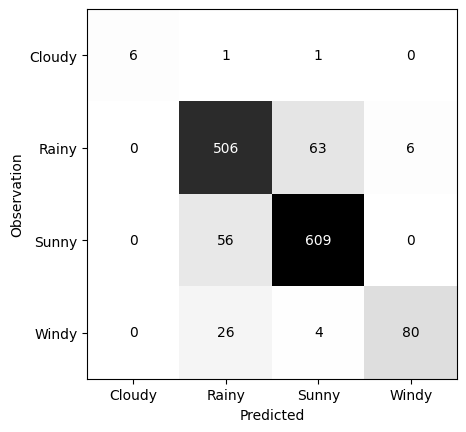

In [18]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = LE.classes_).plot(cmap="binary").im_.colorbar.remove()
plt.xlabel("Predicted")
plt.ylabel("Observation")
plt.show()